In [1]:
!pip install tflite_runtime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 38.0 MB/s eta 0:00:00


In [ ]:
import tflite_runtime

print(tflite_runtime.__version__)

2.5.0.post1


In [2]:
!python3 -m pip install --extra-index-url https://google-coral.github.io/py-repo/ pycoral~=2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://google-coral.github.io/py-repo/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.8/393.8 KB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 3.7 MB/s eta 0:00:00
  Attempting uninstall: tflite-runtime
    Found existing installation: tflite-runtime 2.11.0
    Uninstalling tflite-runtime-2.11.0:
      Successfully uninstalled tflite-runtime-2.11.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
libedgetpu='/content/drive/MyDrive/ColabNotebooks/ImageSegmentation/Lung Segmentation/libedgetpu'

In [ ]:
dir(libedgetpu)

In [ ]:
import argparse

import numpy as np
from PIL import Image

from pycoral.adapters import common
from pycoral.adapters import segment
#from pycoral.utils.edgetpu import make_interpreter
import tflite_runtime.interpreter as tflite

In [ ]:
!echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list

!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

!sudo apt-get update

deb https://packages.cloud.google.com/apt coral-edgetpu-stable main
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1210  100  1210    0     0  29512      0 --:--:-- --:--:-- --:--:-- 29512
OK
Hit:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Get:2 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:3 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Get:4 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Get:5 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease [18.1 kB]
Hit:6 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:7 http://archive.ubuntu.com/ubuntu focal InRelease
Get:8 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:9 https://packages.cloud.google.com/apt coral-edgetpu-stable InRelease [6,332 B]
Ign:10 https://developer.

In [ ]:
!sudo apt-get install libedgetpu1-std

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  libedgetpu1-std
0 upgraded, 1 newly installed, 0 to remove and 33 not upgraded.
Need to get 387 kB of archives.
After this operation, 1,206 kB of additional disk space will be used.
Get:1 https://packages.cloud.google.com/apt coral-edgetpu-stable/main amd64 libedgetpu1-std amd64 16.0 [387 kB]
Fetched 387 kB in 0s (5,911 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to fro

In [ ]:
!pip install edgetpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement edgetpu (from versions: none)
ERROR: No matching distribution found for edgetpu


In [ ]:
!curl https://dl.google.com/coral/edgetpu_api/edgetpu_runtime_20210127.141551_all.deb -o edgetpu_runtime.deb
!sudo dpkg -i edgetpu_runtime.deb

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1449  100  1449    0     0  24150      0 --:--:-- --:--:-- --:--:-- 24150
dpkg-deb: error: 'edgetpu_runtime.deb' is not a Debian format archive
dpkg: error processing archive edgetpu_runtime.deb (--install):
 dpkg-deb --control subprocess returned error exit status 2
Errors were encountered while processing:
 edgetpu_runtime.deb


In [ ]:
def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  indices = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((indices >> channel) & 1) << shift
    indices >>= 3

  return colormap


In [ ]:
def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]

In [ ]:
import numpy as np
import cv2
resized_img = cv2.resize(cv2.imread('test.png'), (128,128))[:,:,0]
resized_img = np.array(resized_img).reshape(1,128,128,1)
np.save("new_input.npy",resized_img)

In [ ]:
# Load the TFLite model
interpreter = tflite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

width, height = common.input_size(interpreter)
print(width,height)

# img = Image.open('test.png')
# # resized_img, _ = common.set_resized_input(
# # interpreter, img.size, lambda size: img.resize(size, Image.ANTIALIAS))
# # print(resized_img)
# print(type(img))
# print(img.size)
# resized_img = img.resize((width, height), Image.ANTIALIAS)
# print(type(resized_img))
# print(resized_img.size)
# resized_img = np.array(resized_img).reshape(128,128,1)
# print(type(resized_img))
# print(resized_img.shape)
# #print(resized_img)
# resized_img=resized_img/255


import cv2
resized_img = cv2.resize(cv2.imread('test.png'), (128,128))[:,:,0]
resized_img = np.array(resized_img).reshape(1,128,128,1)
np.save("new_input.npy",resized_img)
common.set_input(interpreter, resized_img)
interpreter.invoke()

result = segment.get_output(interpreter)
print(result.shape)
result = np.squeeze(result)
print(result.shape)
np.save("result.npy",result)

# If keep_aspect_ratio, we need to remove the padding area.
# new_width, new_height = (128,128)
# result = result[:new_height, :new_width]
mask_img = Image.fromarray(result)

# Concat resized input image and processed segmentation results.
# output_img = Image.new('RGB', (2 * new_width, new_height))
# output_img.paste(resized_img, (0, 0))
# output_img.paste(mask_img, (width, 0))
mask_img.save('result.png')

128 128
(128, 128, 1)
(128, 128)


In [ ]:
import numpy as np
# img = Image.open('test.png')
# Load the array from a file
arr = np.load("new_input.npy")
np.set_printoptions(threshold=np.inf)
print(arr)

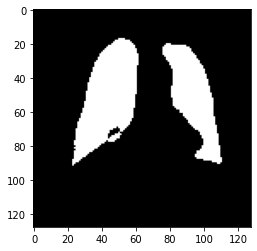

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(arr, cmap="gray")
plt.show()

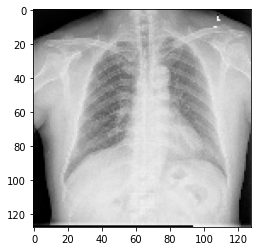

In [ ]:
import matplotlib.pyplot as plt
img = Image.open('test.png')
resized_img = img.resize((width, height), Image.ANTIALIAS)
# Plot the numpy array using imshow
plt.imshow(resized_img, cmap='gray')
# Show the plot
plt.show()

(128, 128, 1)


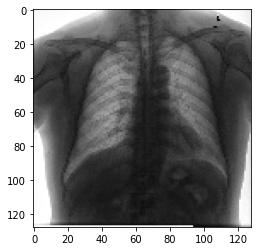

In [ ]:
import matplotlib.pyplot as plt
img = Image.open('test.png')
resized_img = img.resize((width, height), Image.ANTIALIAS)
resized_img = np.array(resized_img).reshape(128,128,1)
print(resized_img.shape)
resized_img=np.squeeze(resized_img)
# Plot the numpy array using imshow
plt.imshow(resized_img, cmap='gray')
# Show the plot
plt.show()

(128, 128)


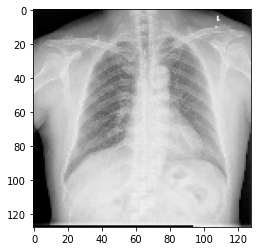

In [ ]:
import matplotlib.pyplot as plt
import cv2
resized_img = cv2.resize(cv2.imread('test.png'), (128,128))[:,:,0]
print(resized_img.shape)
# Plot the numpy array using imshow
plt.imshow(resized_img, cmap='gray')
# Show the plot
plt.show()

In [ ]:
# Load the TFLite model
interpreter = tflite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

resized_img=np.load('input.npy')
common.set_input(interpreter, resized_img)
interpreter.invoke()

result = segment.get_output(interpreter)
print(result.shape)
result = np.squeeze(result)
print(result.shape)
np.save("result.npy",result)

mask_img = Image.fromarray(result)
mask_img.save('result.png')

(128, 128, 1)
(128, 128)


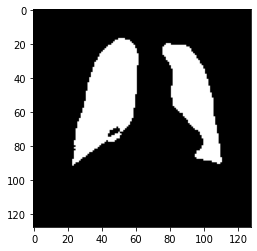

In [ ]:
import matplotlib.pyplot as plt
arr = np.load("result.npy")
plt.imshow(arr, cmap="gray")
plt.show()

In [3]:
import numpy as np
import tflite_runtime.interpreter as tflite
import os
import time
import platform
import argparse

_EDGETPU_SHARED_LIB = {
  'Linux': 'libedgetpu.so.1',
  'Darwin': 'libedgetpu.1.dylib',
  'Windows': 'edgetpu.dll'
}[platform.system()]

In [4]:
model_path = "model.tflite"

In [5]:
if 'edgetpu.tflite'  in model_path:
    interpreter = tflite.Interpreter(
        model_path=model_path, experimental_delegates=[tflite.load_delegate(_EDGETPU_SHARED_LIB,  {})])
else:
    interpreter = tflite.Interpreter(model_path=model_path)

In [ ]:
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_shape = input_details[0]['shape']
#input_data = np.array(np.random.random_sample(input_shape), dtype=input_details[0]['dtype'])
input_data=np.load('input.npy')
input_data=np.float32(input_data)
input_data=np.array(input_data).reshape(1,128,128,1)
interpreter.set_tensor(input_details[0]['index'], input_data)

In [ ]:
interpreter.invoke()

In [ ]:
output_data = interpreter.get_tensor(output_details[0]['index'])
output_img=output_data[0,:,:,0]
np.save("result.npy",output_img)